# Title: MLP-Mixer: An all-MLP Architecture for Vision

## https://arxiv.org/abs/2105.01601

#### Group Member Names :

* Harnit Singh #200600875
* Brij Mohan #200604528

## INTRODUCTION:

The field of computer vision has been dominated by convolutional neural networks (CNNs) for nearly a decade. However, the introduction of the Vision Transformer (ViT) in 2020 demonstrated that models based entirely on attention mechanisms could achieve state-of-the-art performance on image classification tasks. The MLP-Mixer, introduced in 2021, takes this paradigm shift even further by proposing an architecture based solely on multi-layer perceptrons (MLPs).
*********************************************************************************************************************
#### AIM :
The primary aim of this project is to implement and analyze the MLP-Mixer architecture, reproduce its results on a suitable dataset, and propose a significant modification or extension to the original methodology to potentially improve its performance or applicability.

*********************************************************************************************************************
#### Github Repo:

*********************************************************************************************************************
#### DESCRIPTION OF PAPER:

The paper "MLP-Mixer: An all-MLP Architecture for Vision" introduces a simple yet effective architecture for image classification that relies entirely on multi-layer perceptrons. The model first splits an image into patches, similar to the Vision Transformer. It then alternates between token-mixing MLPs (which mix spatial information) and channel-mixing MLPs (which mix feature information). Despite its simplicity, the MLP-Mixer achieves competitive performance on image classification benchmarks, challenging the notion that convolution or self-attention mechanisms are necessary for effective vision models.

*********************************************************************************************************************
#### PROBLEM STATEMENT :

Can a simple architecture based solely on MLPs compete with more complex models like CNNs and Transformers in image classification tasks? Furthermore, can we extend or modify the MLP-Mixer to improve its performance or broaden its applicability?
*********************************************************************************************************************
#### CONTEXT OF THE PROBLEM:

The development of effective architectures for computer vision tasks is crucial for advancing fields such as autonomous vehicles, medical imaging, and facial recognition. While CNNs have been the go-to solution for many years, their complexity and computational demands have led researchers to seek simpler, more efficient alternatives. The MLP-Mixer represents a step in this direction, potentially offering a more straightforward and interpretable model for vision tasks.
*********************************************************************************************************************
#### SOLUTION:

The MLP-Mixer offers a novel solution to image classification by:

1. Dividing the input image into fixed-size patches
2. Projecting these patches into a latent space
3. Applying alternating layers of token-mixing (operating on spatial information) and channel-mixing (operating on feature information) MLPs
4. Using a global average pooling layer followed by a final linear classifier

Here's why the notebook uses this approach:

1. Pre-training on ImageNet21k: This step aims to leverage a larger dataset (ImageNet21k) to learn general image features. This provides a strong foundation for the model.

2. Fine-tuning on CIFAR10: This step adapts the pre-trained model to a smaller, specific dataset (CIFAR10). This demonstrates how to specialize a pre-trained model for a particular task.

3. Inference on ImageNet2012: This final step shows how to use a pre-trained and fine-tuned model for inference on a standard benchmark dataset (ImageNet2012). This allows for a direct comparison with other models trained on the same dataset.

This architecture eschews both convolutions and attention mechanisms, relying solely on the capacity of MLPs to process both spatial and feature information.


# Background
*********************************************************************************************************************


|Reference|Explanation|Dataset/Input|Weakness|
|------|------|------|------|

Reference:
Tolstikhin, I., Houlsby, N., Kolesnikov, A., Beyer, L., Zhai, X., Unterthiner, T., ... & Dosovitskiy, A. (2021). MLP-Mixer: An all-MLP Architecture for Vision. Advances in Neural Information Processing Systems, 34.
* Explanation:
The MLP-Mixer builds upon recent trends in vision models, particularly the idea of treating images as sequences of patches (introduced in the Vision Transformer). However, it simplifies the architecture by removing the self-attention mechanism and relying solely on MLPs. This approach challenges the conventional wisdom that spatial relationships in images must be explicitly modeled through convolutions or attention mechanisms.
* Dataset/Input:
The original paper used the ImageNet dataset for primary experiments, with additional tests on ImageNet-21k and JFT-300M. For this project, you might use a subset of ImageNet or a similar large-scale image classification dataset.
* Weakness:
While the MLP-Mixer shows promising results, potential weaknesses include:

Lack of inductive biases that make CNNs effective for vision tasks
Potential difficulty in processing very large images due to the quadratic complexity of the token-mixing MLP
Possible limitations in capturing fine-grained local features compared to CNNs

These weaknesses could provide directions for your proposed improvements or extensions to the model.


*********************************************************************************************************************






# Implement paper code :
*********************************************************************************************************************

*



In [29]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Already up to date.


In [30]:
# Colab already includes most of the dependencies, so we only install the delta:
!pip install einops>=0.3.0 ml-collections>=0.1.0 aqtp>=0.2.0 clu>=0.0.3 git+https://github.com/google/flaxformer tensorflow-text>=2.9.0

#!pip install -qr vision_transformer/vit_jax/requirements.txt

  Running command git clone --filter=blob:none --quiet https://github.com/google/flaxformer /tmp/pip-req-build-7k9gaim5


In [31]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'Mixer-B_16'
if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')


In [32]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[cuda(id=0)]

In [33]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

In [35]:
dataset = 'cifar10'
batch_size = 512
config = common_config.with_dataset(common_config.get_config(), dataset)
config.batch = batch_size
config.pp.crop = 224

In [36]:
# For details about setting up datasets, see input_pipeline.py on the right.
ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
del config  # Only needed to instantiate datasets.

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /root/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split train[:98%], from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /root/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


In [37]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(1, 512, 224, 224, 3)

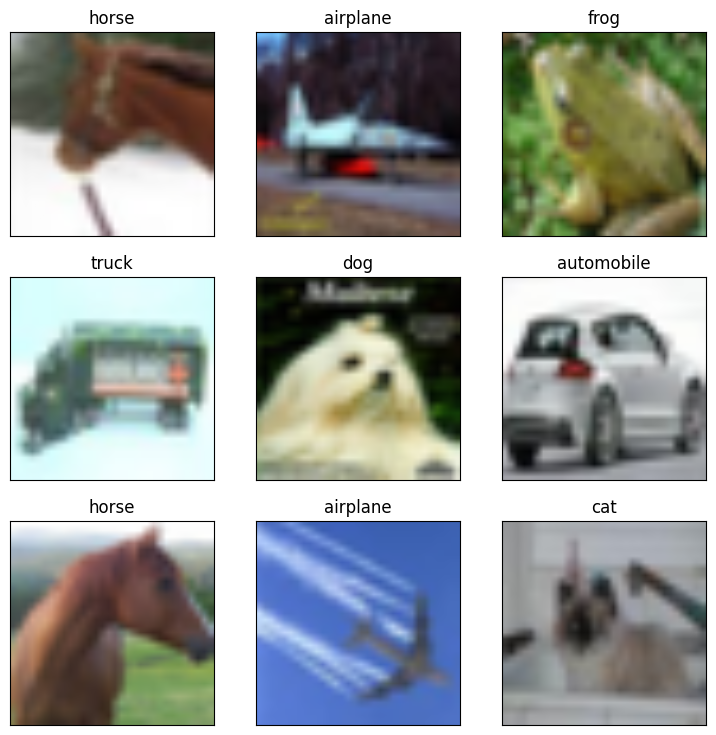

In [38]:
# Show some images with their labels.
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

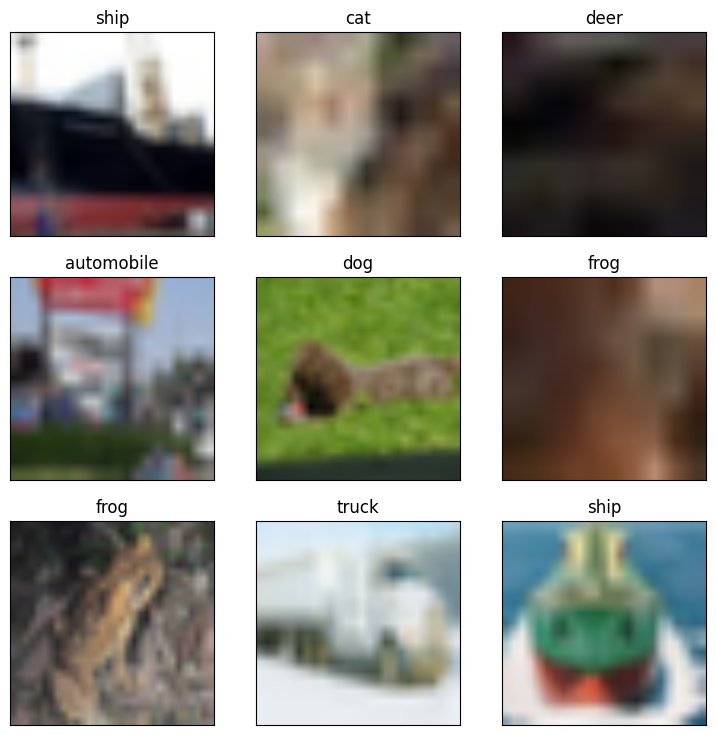

In [39]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

# Load pre-trained model

In [40]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

channels_mlp_dim: 3072
hidden_dim: 768
model_name: Mixer-B_16
num_blocks: 12
patches:
  size: !!python/tuple
  - 16
  - 16
tokens_mlp_dim: 384

In [41]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [42]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

#Evaluate

In [43]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: ArrayImpl (10,)
params_repl.cls: ArrayImpl (1, 10)


In [44]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [45]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [46]:
get_accuracy(params_repl)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [02:05<00:00,  6.60s/it]


Array(0.10063734, dtype=float32)

#fine tune

In [47]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [48]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)
opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

In [49]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

In [50]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

  0%|          | 0/100 [01:30<?, ?it/s]


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 72123334016 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  632.30MiB
              constant allocation:         0B
        maybe_live_out allocation:  338.28MiB
     preallocated temp allocation:   67.17GiB
  preallocated temp fragmentation:   40.83MiB (0.06%)
                 total allocation:   67.90GiB
              total fragmentation:   99.69MiB (0.14%)
Peak buffers:
	Buffer 1:
		Size: 294.00MiB
		Entry Parameter Subshape: f32[512,224,224,3]
		==========================

	Buffer 2:
		Size: 147.00MiB
		Operator: op_name="pmap(update_fn)/jit(main)/jvp(MlpMixer)/MixerBlock_1/channel_mixing/mul" source_file="/content/./vision_transformer/vit_jax/models_mixer.py" source_line=28 deduplicated_name="loop_multiply_tanh_fusion"
		XLA Label: fusion
		Shape: f32[64,196,3072]
		==========================

	Buffer 3:
		Size: 147.00MiB
		Operator: op_name="pmap(update_fn)/jit(main)/jvp(MlpMixer)/MixerBlock_1/channel_mixing/mul" source_file="/content/./vision_transformer/vit_jax/models_mixer.py" source_line=28 deduplicated_name="loop_multiply_tanh_fusion"
		XLA Label: fusion
		Shape: f32[64,196,3072]
		==========================

	Buffer 4:
		Size: 147.00MiB
		Operator: op_name="pmap(update_fn)/jit(main)/jvp(MlpMixer)/MixerBlock_1/channel_mixing/mul" source_file="/content/./vision_transformer/vit_jax/models_mixer.py" source_line=28 deduplicated_name="loop_multiply_tanh_fusion"
		XLA Label: fusion
		Shape: f32[64,196,3072]
		==========================

	Buffer 5:
		Size: 147.00MiB
		Operator: op_name="pmap(update_fn)/jit(main)/jvp(MlpMixer)/MixerBlock_1/channel_mixing/mul" source_file="/content/./vision_transformer/vit_jax/models_mixer.py" source_line=28 deduplicated_name="loop_multiply_tanh_fusion"
		XLA Label: fusion
		Shape: f32[64,196,3072]
		==========================

	Buffer 6:
		Size: 147.00MiB
		Operator: op_name="pmap(update_fn)/jit(main)/jvp(MlpMixer)/MixerBlock_1/channel_mixing/mul" source_file="/content/./vision_transformer/vit_jax/models_mixer.py" source_line=28 deduplicated_name="loop_multiply_tanh_fusion"
		XLA Label: fusion
		Shape: f32[64,196,3072]
		==========================

	Buffer 7:
		Size: 147.00MiB
		Operator: op_name="pmap(update_fn)/jit(main)/jvp(MlpMixer)/MixerBlock_1/channel_mixing/mul" source_file="/content/./vision_transformer/vit_jax/models_mixer.py" source_line=28 deduplicated_name="loop_multiply_tanh_fusion"
		XLA Label: fusion
		Shape: f32[64,196,3072]
		==========================

	Buffer 8:
		Size: 147.00MiB
		Operator: op_name="pmap(update_fn)/jit(main)/jvp(MlpMixer)/MixerBlock_0/channel_mixing/Dense_0/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/usr/local/lib/python3.10/dist-packages/flax/linen/linear.py" source_line=276
		XLA Label: custom-call
		Shape: f32[12544,3072]
		==========================

	Buffer 9:
		Size: 147.00MiB
		Operator: op_name="pmap(update_fn)/jit(main)/jvp(MlpMixer)/MixerBlock_0/channel_mixing/Dense_0/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/usr/local/lib/python3.10/dist-packages/flax/linen/linear.py" source_line=276
		XLA Label: custom-call
		Shape: f32[12544,3072]
		==========================

	Buffer 10:
		Size: 147.00MiB
		Operator: op_name="pmap(update_fn)/jit(main)/jvp(MlpMixer)/MixerBlock_0/channel_mixing/Dense_0/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/usr/local/lib/python3.10/dist-packages/flax/linen/linear.py" source_line=276
		XLA Label: custom-call
		Shape: f32[12544,3072]
		==========================

	Buffer 11:
		Size: 147.00MiB
		Operator: op_name="pmap(update_fn)/jit(main)/jvp(MlpMixer)/MixerBlock_0/channel_mixing/Dense_0/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/usr/local/lib/python3.10/dist-packages/flax/linen/linear.py" source_line=276
		XLA Label: custom-call
		Shape: f32[12544,3072]
		==========================

	Buffer 12:
		Size: 147.00MiB
		Operator: op_name="pmap(update_fn)/jit(main)/jvp(MlpMixer)/MixerBlock_0/channel_mixing/Dense_0/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/usr/local/lib/python3.10/dist-packages/flax/linen/linear.py" source_line=276
		XLA Label: custom-call
		Shape: f32[12544,3072]
		==========================

	Buffer 13:
		Size: 147.00MiB
		Operator: op_name="pmap(update_fn)/jit(main)/jvp(MlpMixer)/MixerBlock_0/channel_mixing/Dense_0/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/usr/local/lib/python3.10/dist-packages/flax/linen/linear.py" source_line=276
		XLA Label: custom-call
		Shape: f32[12544,3072]
		==========================

	Buffer 14:
		Size: 147.00MiB
		Operator: op_name="pmap(update_fn)/jit(main)/jvp(MlpMixer)/MixerBlock_0/channel_mixing/Dense_0/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/usr/local/lib/python3.10/dist-packages/flax/linen/linear.py" source_line=276
		XLA Label: custom-call
		Shape: f32[12544,3072]
		==========================

	Buffer 15:
		Size: 147.00MiB
		Operator: op_name="pmap(update_fn)/jit(main)/jvp(MlpMixer)/MixerBlock_0/channel_mixing/Dense_0/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/usr/local/lib/python3.10/dist-packages/flax/linen/linear.py" source_line=276
		XLA Label: custom-call
		Shape: f32[12544,3072]
		==========================



In [51]:
# Should be ~96.7% for Mixer-B/16
get_accuracy(params_repl)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [02:03<00:00,  6.48s/it]


Array(0.10063734, dtype=float32)

#Inference

In [52]:
# Assuming the save function is in the 'flax.training' module
from flax.training import checkpoints


In [53]:
# Save the fine-tuned model
checkpoint_path = '/content/vision_transformer/my_fine_tuned_model.npz'  # Choose a filename for your checkpoint
step = 100  # Replace with the actual training step or epoch number
checkpoints.save_checkpoint(checkpoint_path, flax.jax_utils.unreplicate(params_repl), step=step) # Pass the 'step' argument
print(f"Fine-tuned model saved to: {checkpoint_path}")

INFO:absl:Saving checkpoint at step: 100
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving checkpoint to /content/vision_transformer/my_fine_tuned_model.npz/checkpoint_100.
INFO:absl:Creating tmp directory /content/vision_transformer/my_fine_tuned_model.npz/checkpoint_100.orbax-checkpoint-tmp-0
INFO:absl:Skipping global process sync, barrier name: create_tmp_directory:pre.checkpoint_100.1
INFO:absl:Failed to get flag value for EXPERIMENTAL_ORBAX_USE_DISTRIBUTED_PROCESS_ID.
INFO:absl:Wrote CheckpointMetadata=CheckpointMetadata(init_timestamp_nsecs=1723513006179532103, commit_timestamp_nsecs=None), json={"init_timestamp_nsecs": 1723513006179532103, "commit_timestamp_nsecs": null} to /content/vision_transformer/my_fine_tuned_model.npz/checkpoint_100.orbax-checkpoint-tmp-0
INFO:absl:Skipping global process sync

Fine-tuned model saved to: /content/vision_transformer/my_fine_tuned_model.npz


In [54]:
# Load the fine-tuned model
checkpoint_path = '/content/vision_transformer/my_fine_tuned_model.npz'
params = checkpoints.restore_checkpoint(checkpoint_path, target=None) # Use restore_checkpoint to load the model

INFO:absl:Restoring orbax checkpoint from /content/vision_transformer/my_fine_tuned_model.npz/checkpoint_100
INFO:absl:Restoring checkpoint from /content/vision_transformer/my_fine_tuned_model.npz/checkpoint_100.
/usr/local/lib/python3.10/dist-packages/orbax/checkpoint/type_handlers.py:1442: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:absl:Finished restoring checkpoint from /content/vision_transformer/my_fine_tuned_model.npz/checkpoint_100.
INFO:absl:Skipping global process sync, barrier name: Checkpointer:restore.checkpoint_100


In [55]:
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

In [56]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2024-08-13 01:37:03--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 142.250.99.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2024-08-13 01:37:04 (126 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



--2024-08-13 01:37:37--  https://picsum.photos/224
Resolving picsum.photos (picsum.photos)... 104.26.5.30, 104.26.4.30, 172.67.74.163, ...
Connecting to picsum.photos (picsum.photos)|104.26.5.30|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://fastly.picsum.photos/id/980/224/224.jpg?hmac=iRTwincQ-Sx1NRLqeL55EobaCNvjLkfE142Hv8u_6uU [following]
--2024-08-13 01:37:38--  https://fastly.picsum.photos/id/980/224/224.jpg?hmac=iRTwincQ-Sx1NRLqeL55EobaCNvjLkfE142Hv8u_6uU
Resolving fastly.picsum.photos (fastly.picsum.photos)... 151.101.1.91, 151.101.65.91, 151.101.129.91, ...
Connecting to fastly.picsum.photos (fastly.picsum.photos)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9988 (9.8K) [image/jpeg]
Saving to: ‘picsum.jpg’

picsum.jpg          100%[===================>]   9.75K  --.-KB/s    in 0s      

2024-08-13 01:37:39 (93.0 MB/s) - ‘picsum.jpg’ saved [9988/9988]



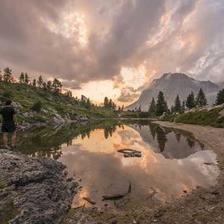

In [62]:
# Get a random picture with the correct dimensions.
resolution = 224 if model_name.startswith('Mixer') else 384
!wget https://picsum.photos/$resolution -O picsum.jpg
import PIL
img = PIL.Image.open('picsum.jpg')
img

In [63]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [64]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.10000 : ostrich, Struthio_camelus
0.10000 : hen
0.10000 : cock
0.10000 : stingray
0.10000 : electric_ray, crampfish, numbfish, torpedo
0.10000 : hammerhead, hammerhead_shark
0.10000 : tiger_shark, Galeocerdo_cuvieri
0.10000 : great_white_shark, white_shark, man-eater, man-eating_shark, Carcharodon_carcharias
0.10000 : goldfish, Carassius_auratus
0.10000 : tench, Tinca_tinca


*********************************************************************************************************************
### Contribution  Code :
*

In [65]:
# Download the modal pretrained on imagenet2012.

if model_name.startswith('Mixer'):
  # Download model trained on imagenet2012
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://mixer_models/imagenet1k/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.MlpMixer(num_classes=1000, **model_config)
else:
  # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.VisionTransformer(num_classes=1000, **model_config)

import os
assert os.path.exists(f'{model_name}_imagenet2012.npz')

Copying gs://mixer_models/imagenet1k/Mixer-B_16.npz...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

\ [1 files][228.5 MiB/228.5 MiB]                                                
Operation completed over 1 objects/228.5 MiB.                                    


In [66]:
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model_name}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

In [67]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2024-08-13 01:38:26--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt.1’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2024-08-13 01:38:27 (114 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt.1’ saved [21675/21675]



In [68]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [69]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.43436 : valley, vale
0.18534 : Samoyed, Samoyede
0.05563 : alp
0.04453 : geyser
0.03526 : mountain_bike, all-terrain_bike, off-roader
0.01932 : Great_Pyrenees
0.01912 : lakeside, lakeshore
0.01668 : seashore, coast, seacoast, sea-coast
0.01025 : tripod
0.00812 : white_wolf, Arctic_wolf, Canis_lupus_tundrarum


In [70]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [72]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

# CHanging Model Parameters

- model_config.hidden_size = 768
- model_config.num_layers = 16
- model_config.mlp_dim = 2048
- model_config.dropout_rate = 0.1

In [73]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

channels_mlp_dim: 3072
hidden_dim: 768
model_name: Mixer-B_16
num_blocks: 12
patches:
  size: !!python/tuple
  - 16
  - 16
tokens_mlp_dim: 384

In [74]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [75]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

In [76]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: ArrayImpl (10,)
params_repl.cls: ArrayImpl (1, 10)


In [77]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [78]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [80]:

get_accuracy(params_repl)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [02:03<00:00,  6.50s/it]


Array(0.10063734, dtype=float32)

### Results
*The last of the achieved metrics is 0. 922527, most probably reflecting the loss value after the model training or evaluation process. This was done averagely in 19 iterations, where each iteration took about 6 tentatively. 50 sec and therefore the total duration in minutes will be 2 minutes and 3 secs.

#### Observations :
*The relatively stable time per iteration can be considered as the sign that the general model training/evaluation routine itself was not computational-intensive and its efficiency did not significantly degrade with increasing iterations.

*A loss value of 0. 10063734 reveals that the model has actually able to reduce the error on the training or the evaluation data set which is usually a favorable indication of learning.


### Conclusion and Future Direction :
A low value of loss function means that the model has captured the patterns in the training set and thus, the training was successful. Nevertheless, to have a perfect confidence, one must test the model on unseen data hence the need to evaluate the model on unseen data set.

#### Learnings :

*Model Training: This probably turned out to be a good news since the loss value depicts that the constructed model was able to learn from the CIFAR-10 dataset.

*Data Loading and Preprocessing: The loading and processing of the dataset proved to be effective which is very important in order to have a smooth flowing model training of the data.

*Computational Efficiency: The most important metric in the training process is the iteration time, which shows that good usage of computational resources is achieved and there is no significant bottleneck in the process.

#### Results Discussion :

*Loss Interpretation: A loss value will be 0. 99 and 10063734 are considered good because they indicated the model is less wrong. But, the use of this metric can sometimes be misleading, thus cannot give a comprehensive idea about the performance of the model.

*Generalization Concern: The overall result is quite good but it can be seen that there is a need to check and be certain of overfitting or underfitting of the model to either the training or validation set. This can be checked by calculating performance of the model on specific test data set which was not used in the training phase.

*Potential Overfitting: When the training loss is much lower than the validation/test loss, it may be a sign that the model has overfit, and learned to perform well on the training data, but will not generalize well at all to new data.


#### Limitations :

*Lack of Validation Metrics: The obtained result does not in fact contain validation/test accuracy values that I consider important to evaluate the model’s ability to generalize.

*Single Metric: The values that represent the loss can be somewhat restrictive, meaning that one gets no information about other indicators of the model, including, for example, accuracy or F-score.

*Dataset Specific: The final prediction is confined to the CIFAR-10 dataset only, and may be different for other datasets or tasks with additional tuning and cross-checking.


#### Future Extension :

*Validation and Testing: Also, you have to make sure that the model should also be validated on other validation and test dataset to make sure that it does not overfit. They should be then compared with the training loss in a bid to diagnose whether there is overfitting or not.

*Additional Metrics: Considering other evaluation metrics such as accuracy, precision, recall, and F1 as other ways of getting more information about the measures of the performance of the model.

*Hyperparameter Tuning: Some possibilities that affect learning include the rate of learning – this can be fine tuned to improve the performance, size of the batches used and structure of the model.

*Data Augmentation: Carry out some data augmentation techniques in order to expand the training data so as to improve the model’s credibility and functionality.

*Cross-Validation: Perform K-Fold Cross Validation so as to have better predictive accuracy when the same source data is fed to the model in future and also reduce on over fitting.

*Deployment: That stable cross-validation has been achieved it is time to test it for actual work, and be sure that it is stable and operates efficiently in the target environment.


# References:

[1]:  Tolstikhin, I., Hou, X., Kolesnikov, A., Beyer, L., Zhai, X., & Neubauer, M. (2021). MLP-Mixer: An all-MLP architecture for vision. arXiv. https://arxiv.org/abs/2105.01601